In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.0.8'

# Comprendre les réseaux de neurones récurrents

Une caractéristique majeure de tous les réseaux de neurones que nous avons vus jusqu’à présent, tels que les réseaux à connexions denses, est qu’ils n’ont pas de mémoire. Chaque entrée qui leur est présentée est traitée indépendamment, aucun état n’est maintenu entre les entrées. 

Avec de tels réseaux, pour traiter une séquence ou une série temporelle, vous devez afficher la séquence complète en une fois sur le réseau : transformez-la en un seul point de données. 



En revanche, lors de la lecture d'une phrase, vous la traitez mot par mot, tout en gardant un souvenir de ce qui précédait

L’intelligence biologique traite l’information progressivement tout en conservant un modèle interne de ce qu’elle traite, construit à partir d’informations antérieures et constamment mis à jour au fur et à mesure que de nouvelles informations arrivent.

Un réseau de neurones récurrents (RNN) adopte le même principe, mais dans une version extrêmement simplifiée: il traite les séquences en itérant à travers les éléments de séquence et en maintenant un état contenant des informations relatives à ce qu'il a vu jusqu'à présent. 

Un RNN est un type de réseau de neurones à boucle interne. 

Au cours des dernières années, les RNN ont rencontré un succès incroyable dans de nombreux problèmes: reconnaissance de la parole, modélisation du langage, traduction...

Les RNN représentent la famille de réseau de neurones qui traite les données de manière séquentielles. L’idée principale étant que chaque nouveau mot qui est prédit à partir de notre modèle, prend en compte l’état précédent afin de s’actualiser. L’état représente fondamentalement l’historique - la mémoire utilisée dans le réseau de neurones pour prendre en compte le passé afin de l’utiliser dans la prédiction à l’instant t.


Deux problèmes principaux font suite à cette architecture fondamentale : la disparition du gradient, et son explosion. 


Lors de la backpropagation, on doit calculer un gradient qui est sujet à disparition/explosion. Cette disparition notamment a pour effet de faire “oublier” au RNN des informations qui pourraient pourtant être utiles au traitement actuel. 


Si j’ai un texte dans lequel une information primordiale est présente au début, il est très difficile de créer un RNN qui prenne en compte cette information sur la fin du texte. 


Il existe une grande variété de techniques qui sont utilisés pour gérer ce problème. Notamment en premier lieu, une architecture plus robuste qui a été imaginée quelques années après l’apparition des RNN appelée LSTM (Long Short Term Memory)

In [4]:
from keras.layers import SimpleRNN


Comme toutes les couches récurrentes de Keras, SimpleRNN peut être exécuté dans deux modes différents: 

- il peut renvoyer soit les séquences complètes de sorties successives pour chaque pas temporel (un tenseur 3D de forme (batch_size, timesteps, output_features)), 

- ou seulement la dernière sortie de chaque séquence d'entrée (un tenseur 2D de forme (batch_size, output_features)). 


Ces deux modes sont contrôlés par l'argument du constructeur return_sequences. Examinons un exemple qui utilise SimpleRNN et renvoie uniquement la dernière sortie :

In [1]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

C:\Users\s4d-asus-14\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [2]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________



Il est parfois utile d’empiler plusieurs couches récurrentes afin d’accroître la puissance de représentation d’un réseau. Dans une telle configuration, vous devez faire en sorte que toutes les couches intermédiaires renvoient la séquence complète des sorties:

In [3]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Maintenant, utilisons un tel modèle sur le problème de classification de critiques de films IMDB. Tout d'abord, pré-traiter les données.


In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)



Entraînons un réseau récurrent simple en utilisant une couche `Embedding` et une couche `SimpleRNN`:

In [3]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 15s 753us/step - loss: 0.6412 - acc: 0.6150 - val_loss: 0.4917 - val_acc: 0.7780
Epoch 2/10
20000/20000 [==============================] - 15s 732us/step - loss: 0.4115 - acc: 0.8237 - val_loss: 0.4251 - val_acc: 0.8126
Epoch 3/10
20000/20000 [==============================] - 15s 732us/step - loss: 0.3027 - acc: 0.8784 - val_loss: 0.4824 - val_acc: 0.7756
Epoch 4/10
20000/20000 [==============================] - 16s 785us/step - loss: 0.2224 - acc: 0.9121 - val_loss: 0.3925 - val_acc: 0.8360
Epoch 5/10
20000/20000 [==============================] - 16s 804us/step - loss: 0.1524 - acc: 0.9438 - val_loss: 0.3831 - val_acc: 0.8658
Epoch 6/10
20000/20000 [==============================] - 16s 818us/step - loss: 0.0948 - acc: 0.9677 - val_loss: 0.4980 - val_acc: 0.8094
Epoch 7/10
20000/20000 [==============================] - 18s 913us/step - loss: 0.0596 - acc: 0.9818 - val_loss: 0.4

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()



#  Comprendre les couches LSTM et GRU

- SimpleRNN n'est pas la seule couche récurrente disponible dans Keras. 

- Il y en a deux autres: LSTM et GRU. 


En pratique, vous en utiliserez toujours un, car SimpleRNN est généralement trop simpliste pour être réellement utile. 


SimpleRNN pose un problème majeur: bien qu’il devrait théoriquement être capable de conserver à l’heure t les informations sur les entrées observées plusieurs fois auparavant, dans la pratique, de telles dépendances à long terme sont impossibles à apprendre. 

Cela est dû au problème du gradient qui disparaît, un effet similaire à celui observé avec les réseaux non récurrents (réseaux de prévision) qui ont plusieurs couches de profondeur

Les couches LSTM et GRU sont conçues pour résoudre ce problème.


# Un exemple concret de LSTM à Keras

Nous allons configurer un modèle utilisant une couche LSTM et l’entraîner sur les données IMDB. 

Le réseau est similaire à celui de SimpleRNN qui vient d'être présenté. Vous spécifiez uniquement la dimensionnalité en sortie de la couche LSTM ; laissez tous les autres arguments (il y en a beaucoup) aux valeurs par défaut de Keras. Keras a de bons paramètres par défaut, et les choses fonctionneront presque toujours sans que vous ayez à passer du temps à régler les paramètres à la main.


In [7]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 94s 5ms/step - loss: 0.5106 - acc: 0.7611 - val_loss: 0.3567 - val_acc: 0.8502
Epoch 2/10
20000/20000 [==============================] - 91s 5ms/step - loss: 0.2902 - acc: 0.8858 - val_loss: 0.3198 - val_acc: 0.8628
Epoch 3/10
20000/20000 [==============================] - 87s 4ms/step - loss: 0.2325 - acc: 0.9112 - val_loss: 0.3144 - val_acc: 0.8824
Epoch 4/10
20000/20000 [==============================] - 86s 4ms/step - loss: 0.1971 - acc: 0.9271 - val_loss: 0.5121 - val_acc: 0.8358
Epoch 5/10
20000/20000 [==============================] - 88s 4ms/step - loss: 0.1758 - acc: 0.9359 - val_loss: 0.2861 - val_acc: 0.8828
Epoch 6/10
20000/20000 [==============================] - 91s 5ms/step - loss: 0.1511 - acc: 0.9462 - val_loss: 0.4104 - val_acc: 0.8816
Epoch 7/10
20000/20000 [==============================] - 87s 4ms/step - loss: 0.1441 - acc: 0.9481 - val_loss: 0.3942 - val_acc:

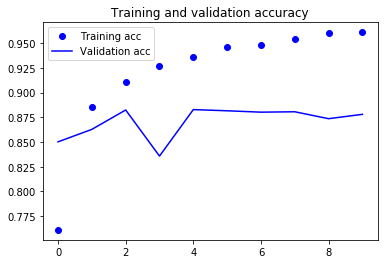

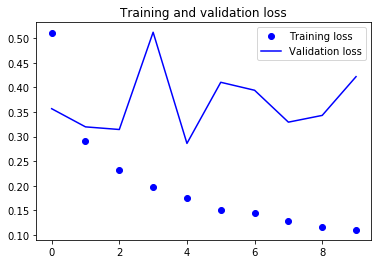

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()